In [16]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


In [22]:
csv = "../../data/contaminated/contaminated_data1.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies.npy").flatten().tolist()

In [45]:
contaminated.size

3419

In [23]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

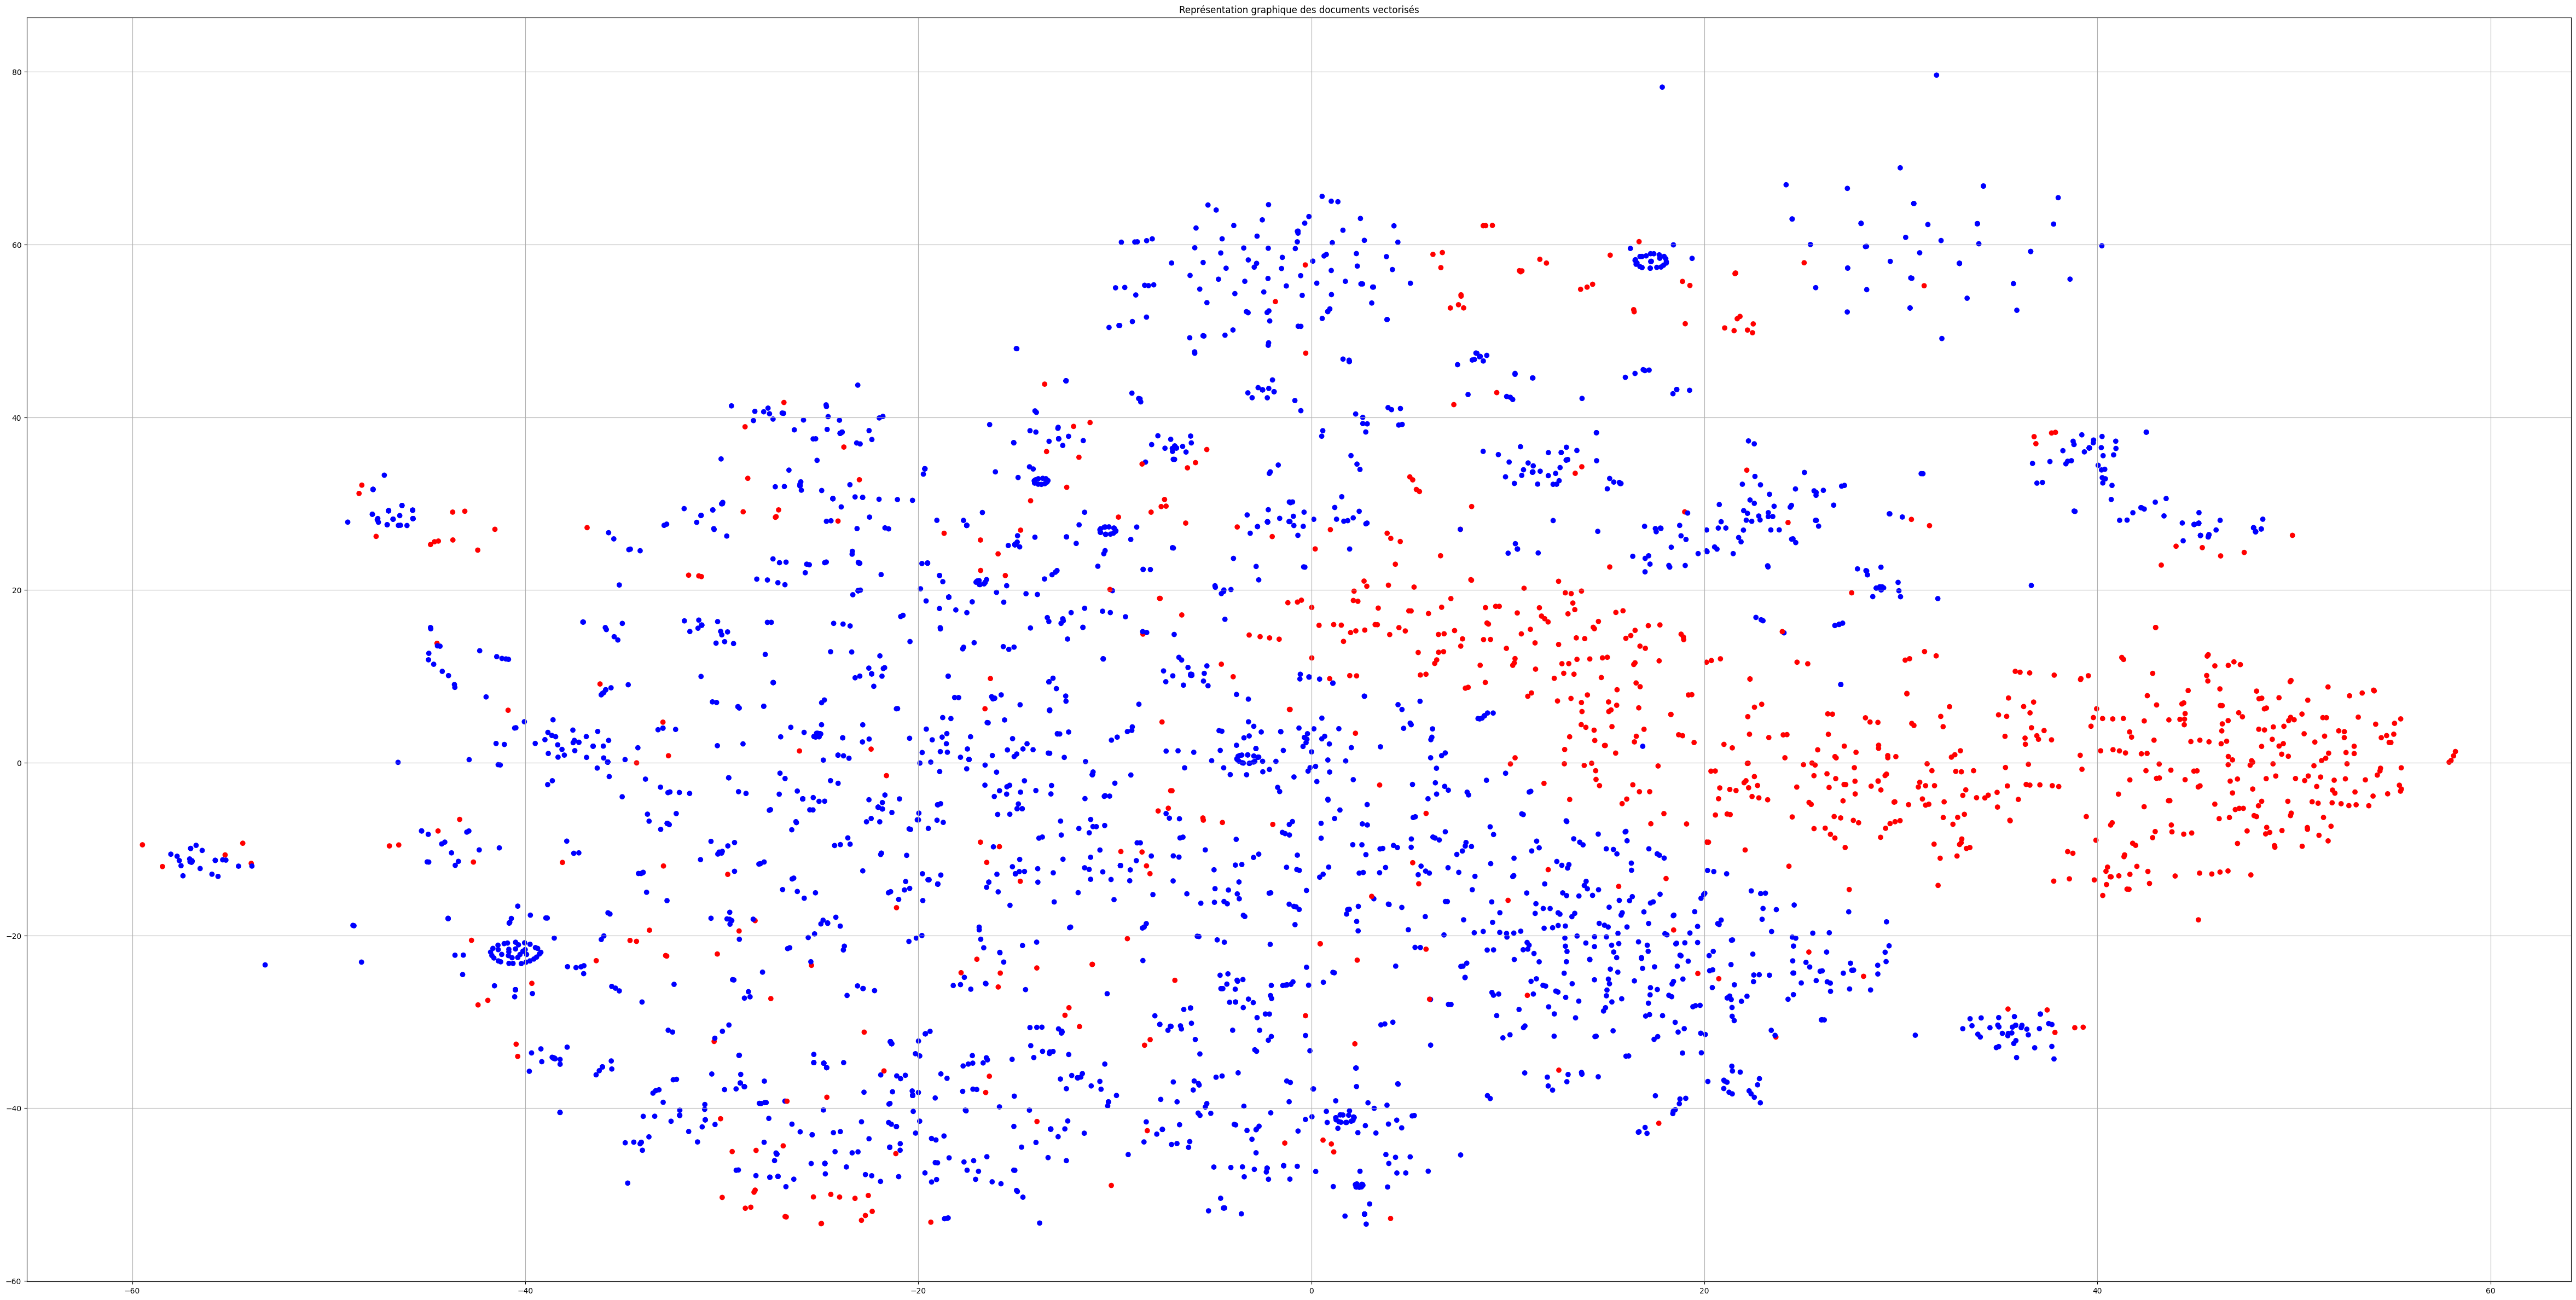

In [24]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [58]:
anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

anomaly_train_idx, anomaly_test_idx = train_test_split(anomaly_indices, test_size=0.2, random_state=42)

normal_train_idx, normal_test_idx = train_test_split(normal_indices, test_size=0.2, random_state=42)

train_indices = anomaly_train_idx + normal_train_idx
test_indices = anomaly_test_idx + normal_test_idx

df_train = anomalie_sb[train_indices]
df_test = anomalie_sb[test_indices]

In [60]:
anomalie_tensor = torch.tensor(df_train, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=df_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0010
Epoch 2/50, Loss: 0.0009
Epoch 3/50, Loss: 0.0007
Epoch 4/50, Loss: 0.0005
Epoch 5/50, Loss: 0.0005
Epoch 6/50, Loss: 0.0005
Epoch 7/50, Loss: 0.0004
Epoch 8/50, Loss: 0.0005
Epoch 9/50, Loss: 0.0005
Epoch 10/50, Loss: 0.0004
Epoch 11/50, Loss: 0.0003
Epoch 12/50, Loss: 0.0004
Epoch 13/50, Loss: 0.0004
Epoch 14/50, Loss: 0.0004
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0004
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0004
Epoch 20/50, Loss: 0.0003
Epoch 21/50, Loss: 0.0004
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0004
Epoch 24/50, Loss: 0.0003
Epoch 25/50, Loss: 0.0005
Epoch 26/50, Loss: 0.0004
Epoch 27/50, Loss: 0.0004
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0004
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0004
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0002
Epoch 38/50, Loss: 0.0004
Epoch 39/50, Loss: 0.


🔥 Meilleur seuil trouvé : 0.000354
📈 F1-score optimal : 0.6024

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.94      0.65      0.77       513
    Anomalie       0.46      0.88      0.60       171

    accuracy                           0.71       684
   macro avg       0.70      0.77      0.69       684
weighted avg       0.82      0.71      0.73       684

AUC ROC : 0.8125


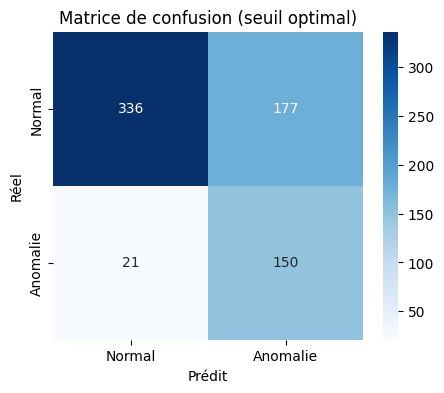

In [69]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(df_test, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.isin(test_indices, anomaly_test_idx).astype(int)

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_score)

print(f"AUC ROC : {roc_auc:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [70]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    684.000000
mean       0.000347
std        0.000192
min        0.000029
25%        0.000185
50%        0.000343
75%        0.000475
max        0.001041
Name: MSE, dtype: float64


In [71]:
isolation_forest = IsolationForest()
isolation_forest.fit(df_train)

IsolationForest()

In [72]:
i_forest = isolation_forest.decision_function(df_test)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.88      0.85      0.86       513
    Anomalie       0.59      0.65      0.62       171

    accuracy                           0.80       684
   macro avg       0.73      0.75      0.74       684
weighted avg       0.81      0.80      0.80       684

🎯 AUC ROC : 0.8383


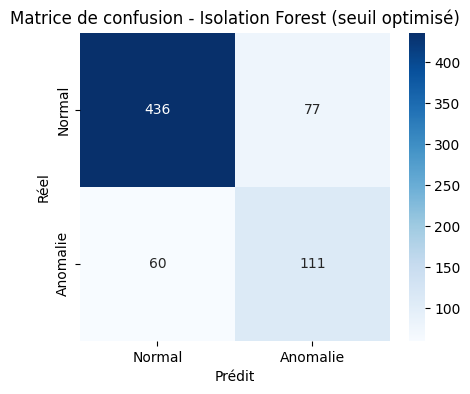

In [73]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [74]:
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05) 
oc_svm.fit(df_train)

OneClassSVM(nu=0.05)

In [75]:
svm_pred = oc_svm.decision_function(df_test)
svm_scores = -svm_pred #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.82      0.51      0.63       513
    Anomalie       0.31      0.67      0.42       171

    accuracy                           0.55       684
   macro avg       0.57      0.59      0.53       684
weighted avg       0.69      0.55      0.58       684

🎯 AUC ROC : 0.5901


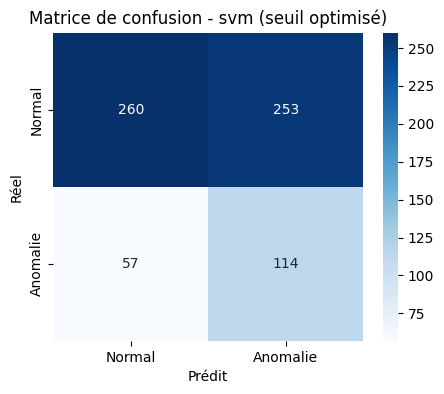

In [77]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - svm (seuil optimisé)")
plt.show()